# Analytical code for the RF model

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
from scipy import integrate as integrate
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
from mpltools import annotation
import torch
import tqdm
import itertools
cmap = plt.get_cmap('viridis')

plt.rcParams.update(plt.rcParamsDefault)
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font',       family='serif')          # controls default text sizes
plt.rc('font',       size=2*MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes',  titlesize=2*MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes',  labelsize=2*MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=2*SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=2*SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=2*SMALL_SIZE)    # legend fontsize
plt.rc('figure',titlesize=2*BIGGER_SIZE)  # fontsize of the figure title
plt.rc("lines", linewidth=3.0)
plt.rcParams["savefig.dpi"] = 500
cmap = plt.get_cmap('Spectral_r')

savedir = './figs-rf/'
datadir = './data/'

import warnings
warnings.filterwarnings('ignore')

In [2]:
def dict_product(d):
    keys = d.keys()
    for element in itertools.product(*d.values()):
        yield dict(zip(keys, element))
        
def select_data(data,constraints):
    data1 = data
    for k,v in constraints.items():
        try:
            data1 = data1[data1[k]==v]
        except:
            print("Error on {}, constraint={}, value={}".format(k,v,data1[k]))
    return data1

def df_to_arrays(df, x_label, y_label, z_label):
    x_vals = df[x_label].unique()
    y_vals = df[y_label].unique()
    X, Y = np.meshgrid(x_vals, y_vals)
    Z = np.zeros((len(x_vals),len(y_vals)))
    for line in df.iterrows():
        line = line[1]
        x, y, z = line[x_label], line[y_label], line[z_label]
        i, j = find(x_vals, x), find(y_vals, y)
        Z[i,j] = z
    return X, Y, Z

def find(array, value):
    idx= np.argwhere(np.array(array)==value)[0,0]
    return idx

# Gaussian equivalence

In [3]:
# Non-linearities and their respective coefficients
NL = {'relu', 'sign', 'tanh', 'erf'}
COEFFICIENTS = {'relu': (1/np.sqrt(2*np.pi), 0.5, np.sqrt((np.pi-2)/(4*np.pi))), 
               'erf': (0, 2/np.sqrt(3*np.pi), 0.200364), 'tanh': (0, 0.605706, 0.165576),
               'sign': (0, np.sqrt(2/np.pi), np.sqrt(1-2/np.pi)), 'linear':(0,1,0),'abs':(np.sqrt(2/np.pi),0,np.sqrt(1-2/np.pi))}

def get_coef(nl, cs):
    if type(nl)==str:
        return COEFFICIENTS[nl]
    else:
        return (0, nl**0.5, (1-nl)**0.5)
    
def get_coef_blocks(nl, cs, ds):
    cs, ds = np.array(cs), np.array(ds)
    V = np.sum(cs*ds)
    kappa_0 = integrate.quad(lambda x : activation(x, nl)     * np.exp(-x**2/(2*V))/np.sqrt(2*np.pi*V), -20, 20)[0]
    kappa_1 = integrate.quad(lambda x : activation(x, nl) * x * np.exp(-x**2/(2*V))/np.sqrt(2*np.pi*V), -20, 20)[0] / V
    kappa_2 = integrate.quad(lambda x : activation(x, nl)**2  * np.exp(-x**2/(2*V))/np.sqrt(2*np.pi*V), -20, 20)[0]
    kappa_star = np.sqrt(kappa_2 - kappa_0**2 - kappa_1**2 * V)
    return kappa_0, kappa_1, kappa_star
        
def activation(x, nonlinearity):
    if nonlinearity == 'linear':
        return x
    if nonlinearity == 'sign':
        return np.sign(x)
    elif nonlinearity == 'relu':
        return np.maximum(x, 0)
    elif nonlinearity =='erf':
        return erf(x)
    elif nonlinearity == 'tanh':
        return np.tanh(x)
    else:
        print('nonlinearity not known')

# Random matrix theory for block matrices

In [4]:
# Stieltjes transform and its derivative for gaussian and orthogonal features.
from scipy.optimize import fsolve, minimize, LinearConstraint

def stieltjes_g(z, gamma, F='gaussian'):
    g, dg = 0, 0
    z = gamma * z 
    if F=='gaussian':
        det = np.sqrt((z-gamma-1)**2 - 4*gamma)
        g = (1-z-gamma-det)/(2*z*gamma)
        dg = -1/(2*z*gamma) * (1 + (z-gamma-1)/det + (1-z-gamma-det)/z) 
    elif F == 'orthogonal':        
        if gamma > 1:
            g = -(1-1/gamma)/z +1/gamma *  1/(gamma-z)
            dg = (1-1/gamma)/z**2 + 1/gamma *  1/(gamma-z)**2
        else:
            g = 1/(1-z)
            dg = 1/(1-z)**2
        
    return gamma*g, gamma**2 *dg

def stieltjes_g_block(z, gamma, Vs, ds, F='gaussian'):
    g, dg = 0, 0
    z = gamma * z 
    
    Vs, ds = np.array(Vs), np.array(ds)
    
    def equations(p):
        qs, dqs = p[:len(p)//2], p[len(p)//2:]
        omega = 1 - np.sum(ds * Vs * qs * gamma)
        eqs = ds*z*omega*qs - Vs*ds*qs - ds*omega
        domega = - np.sum(ds * Vs * dqs * gamma)
        deqs = ds*(omega*qs + z*domega*qs + z*omega*dqs) - Vs*ds*dqs - ds*domega
        return np.concatenate([eqs, deqs])
    
    sol = -fsolve(equations, (np.ones(len(Vs))/z,np.ones(len(Vs))))
    qs, dqs = sol[:len(sol)//2], sol[len(sol)//2:]
    g = ds * qs
    dg = ds * dqs
            
    return gamma*g, gamma**2 *dg

# Saddle-point equations

In [5]:
def iterate_se(alpha, gamma, lamb, delta=0, nl='erf', F='gaussian',
               max_iter=int(1e3), eps=1e-5, init_condition='uninformed', task='classification',
              cs=[1,2], ds=[.5, .5], betas=[1,1], coef_damping=.5):
    """ 
    Update state evolution equations. 
    
    Parameters:
    * eps = threshold to reach convergence.
    * max_iter = maximum number of steps if convergence not reached.
    """
    
    # Initialise qu and qv
    Vx = np.zeros((max_iter,len(cs)))
    qx = np.zeros((max_iter,len(cs)))
    mx = np.zeros((max_iter,len(cs)))

    Vw = np.zeros(max_iter)
    qw = np.zeros(max_iter)
    
    ones = ds
    if init_condition == 'uninformed':
        Vx[0], qx[0], mx[0] = 0.001*ones, 0.001*ones, 0.001*ones
        Vw[0], qw[0] = 0.001, 0.001
        
    elif init_condition == 'informed':
        Vx[0], qx[0], mx[0] = 0.999*ones, 0.999*ones, 0.999*ones
        Vw[0], qw[0] = 0.999, 0.999
        
    for t in range(max_iter - 1):
        if task=='classification':
            Vxtmp, qxtmp, mxtmp, Vwtmp, qwtmp = update_classification(Vx[t], qx[t], mx[t], Vw[t], qw[t], 
                                                          alpha, gamma, lamb, delta, nl=nl, F=F, cs=cs, ds=ds, betas=betas, iter=t)          
        elif task=='regression':
            Vxtmp, qxtmp, mxtmp, Vwtmp, qwtmp = update_regression(Vx[t], qx[t], mx[t], Vw[t], qw[t],
                                                          alpha, gamma, lamb, delta, nl=nl, F=F, cs=cs, ds=ds, betas=betas, iter=t)  
            
        def damping(q_new, q_old):
            return (1 - coef_damping) * q_new + coef_damping * q_old

        
        Vx[t + 1], qx[t + 1], mx[t+1] = damping(Vxtmp, Vx[t]), damping(qxtmp, qx[t]), damping(mxtmp, mx[t])
        Vw[t + 1], qw[t + 1] = damping(Vwtmp, Vw[t]), damping(qwtmp, qw[t])
                
        diff = np.abs(Vx[t + 1] - Vx[t]).sum() + np.abs(qx[t + 1] - qx[t]).sum() + np.abs(mx[t + 1] - mx[t]).sum()
        diff += np.abs(Vw[t + 1] - Vw[t]) + np.abs(qw[t + 1] - qw[t])
        
        if diff < eps or np.isnan(diff):
            break
            
        #print(Vx[t], qx[t], mx[t], Vw[t], qw[t])
        #if t==2: break
                
    return Vx[t], qx[t], mx[t], Vw[t], qw[t], t

In [6]:
# One step update of saddle-point equations
def update_classification(Vx, qx, mx, Vw, qw, alpha, gamma, lamb, delta, nl='erf',  F='gaussian', cs=[1,1], ds=[0.5,0.5], betas=[1,1], iter=0):
    
    M = mu1 *    (mx * cs).sum()
    Q = mu1**2 * (qx * cs).sum() + mustar**2 * qw 
    V = mu1**2 * (Vx * cs).sum() + mustar**2 * Vw
    rho = (cs * betas * ds).sum()
    
    c1 = 1/(1+V)
    noise_factor1 = 1-2*delta
    noise_factor2 = 1-2*delta
    
    mxhat = cs*alpha/gamma * mu1 * c1 * np.sqrt(2/np.pi) * noise_factor2
    Vxhat = cs*alpha/gamma * mu1**2 * c1
    qxhat = cs*alpha/gamma * mu1**2 * c1**2 * (rho + Q - 2*noise_factor1*M * np.sqrt(2/np.pi))    

    Vwhat = (alpha/gamma) * mustar**2 * c1
    qwhat = (alpha/gamma) * mustar**2 * c1**2 * (rho + Q - 2*noise_factor1*M * np.sqrt(2/np.pi))
    
    z = (lamb+Vwhat)
    g, dg = stieltjes_g_block(-z, gamma, Vxhat, ds, F=F)
    
    Vxnew =  (ds - z * g)/Vxhat
    mxnew =  (betas * mxhat) * Vxnew 
    qxnew =  (betas * mxhat**2 + qxhat)/Vxhat**2 * (ds - 2*z*g + z**2 * dg) - qwhat/(lamb+Vwhat)/Vxhat * (-z*g + z**2 * dg)
        
    Vwnew = (1/gamma - 1 + z*np.sum(g))/(Vwhat+lamb)
    qwnew = qwhat/(lamb+Vwhat)**2 * (1/gamma - 1 + z**2 * np.sum(dg)) - np.sum((betas * mxhat**2 + qxhat)/(Vxhat*(lamb+Vwhat)) * (-z*g+ z**2 * dg))

    return Vxnew, qxnew, mxnew, Vwnew, qwnew


def update_regression(Vx, qx, mx, Vw, qw, alpha, gamma, lamb, delta, nl='erf',  F='gaussian', cs=[1,2], ds=[.5, .5], betas=[1,1], iter=0):

    M = mu1 *    (mx * cs).sum()
    Q = mu1**2 * (qx * cs).sum() + mustar**2 * qw 
    V = mu1**2 * (Vx * cs).sum() + mustar**2 * Vw
    rho = (cs * betas * ds).sum()
    
    c1 = 1/(1+V)

    mxhat = cs*alpha/gamma * mu1    * c1
    Vxhat = cs*alpha/gamma * mu1**2 * c1 
    qxhat = cs*alpha/gamma * mu1**2 * c1**2 * (rho + Q + delta - 2*M) 
    
    Vwhat = alpha/gamma * mustar**2 * c1
    qwhat = alpha/gamma * mustar**2 * c1**2 * (rho + Q + delta - 2*M)
    
    z = (lamb+Vwhat)
    g, dg = stieltjes_g_block(-z, gamma, Vxhat, ds, F=F)
    
    Vxnew =  (ds - z * g)/Vxhat
    mxnew =  (betas * mxhat) * Vxnew 
    qxnew =  (betas * mxhat**2 + qxhat)/Vxhat**2 * (ds - 2*z*g + z**2 * dg) - qwhat/(lamb+Vwhat)/Vxhat * (-z*g + z**2 * dg)
        
    Vwnew = (1/gamma - 1 + z*np.sum(g))/(Vwhat+lamb)
    qwnew = qwhat/(lamb+Vwhat)**2 * (1/gamma - 1 + z**2 * np.sum(dg)) - np.sum((betas * mxhat**2 + qxhat)/(Vxhat*(lamb+Vwhat)) * (-z*g+ z**2 * dg))

    return Vxnew, qxnew, mxnew, Vwnew, qwnew

# Runs

In [ ]:
# SAMPLE-WISE
Psi1s = [1]
Psi2s = np.logspace(-3,3,60)
# PARAMETER-WISE
Psi2s = [1]
Psi1s = np.logspace(-3,3,60)
# PHASE-SPACE
Psi1s = np.logspace(-2,4,15)
Psi2s = np.logspace(-2,4,15)
#Psi1s = np.logspace(-3,3,15)
#Psi2s = np.logspace(-3,3,15)

lambs = [1e-1]
nls = ['relu']
deltas = [0.,]
Fs= ['gaussian']
tasks= ['classification']

data = {'task':[], 'nonlinearity': [], 'F': [], 'alpha': [], 'Psi1': [], 'Psi2': [], 'gamma':[], 'delta':[], 'rphi':[], 'rx':[], 'rb':[],
        'Vx': [], 'qx': [], 'mx': [], 'Vw': [], 'qw': [], 'Q':[], 'M':[], 'V':[], 'te_error':[], 'tr_error':[], 't': [], 'lamb': []}

rphis = []
rphis = [10]
rxs   = [1,10]
rbs   = [10]

rphis = [100]
rxs   = [1,100]
rbs   = [0.01,1,100]

rphis = [100]
rxs   = [1,10,100,1000]
rbs   = [1000]

for nonlinearity in nls:
    for iPsi1,Psi1 in enumerate(Psi1s):
        for iPsi2, Psi2 in enumerate(Psi2s):
            for ilamb, lamb in enumerate(lambs):
                print(iPsi1, iPsi2, ilamb, end=' ')
                for task in tasks:
                        for F in Fs:
                            for delta in deltas:
                                for rx in rxs:
                                    for rb in rbs:
                                        if rx==1 and rb!=rbs[0]: continue
                                        if rx==0.1 and rb<1: continue
                                        for rphi in rphis:
                                            
                                            ds = np.array([1/rphi, 1-1/rphi])
                                            cs = np.array([rx/(rx*ds[0]+ds[1]), 1/(rx*ds[0]+ds[1])])
                                            betas = np.array([rb/(rb*ds[0]*cs[0]+ds[1]*cs[1]), 1/(rb*ds[0]*cs[0]+ds[1]*cs[1])])

                                            mu0, mu1, mustar = get_coef_blocks(nonlinearity, cs, ds)

                                            alpha = Psi2/Psi1
                                            gamma = 1/Psi1

                                            Vx, qx, mx, Vw, qw, t = iterate_se(alpha, gamma, lamb, delta=delta,nl=nonlinearity, 
                                                                               F=F, init_condition='uninformed', task=task, 
                                                                               cs=cs, ds=ds, betas=betas,
                                                                               max_iter=int(1e2), eps=1e-5, coef_damping=0.5)


                                            rho = (betas * cs * ds).sum()
                                            M = mu1 *    (mx*cs).sum()
                                            Q = mu1**2 * (qx*cs).sum() + mustar**2 * qw 
                                            V = mu1**2 * (Vx*cs).sum() + mustar**2 * Vw 
    
                                            if task == 'classification':
                                                te_error = (1/np.pi) * np.arccos(M/np.sqrt(Q*rho))
                                                tr_error = 1/((1+V)**2) * ( te_error + delta/2 ) #(rho + Q - 2 * (1-2*delta) *M ) / (2*(1+V)**2)
                                            else:
                                                te_error = (rho + Q - 2*M) / 2
                                                tr_error = 1/((1+V)**2) * ( te_error + delta/2 )
                                            
                                            if not np.isnan(te_error) and te_error>0:
                                                for k in data:
                                                    data[k].append(eval(k))
                                                
data = pd.DataFrame.from_dict(data)

In [140]:
#torch.save(data, datadir+'parameter_wise.pkl')
#torch.save(data, datadir+'sample_wise.pkl')
#torch.save(data, datadir+'regularization.pkl')
#torch.save(data, datadir+'phase_space.pkl')
#torch.save(data, datadir+'varying_rphi_parameter_wise.pkl')
#torch.save(data, datadir+'varying_rphi_sample_wise.pkl')

# 2d plots

In [129]:
# SAMPLE-WISE
#data = torch.load(datadir+'sample_wise.pkl')

#PARAMETER-WISE
#data = torch.load(datadir+'parameter_wise.pkl')

data = pd.DataFrame.from_dict(data)

{'nonlinearity': 'tanh', 'lamb': 0.001, 'task': 'classification', 'delta': 0.0}


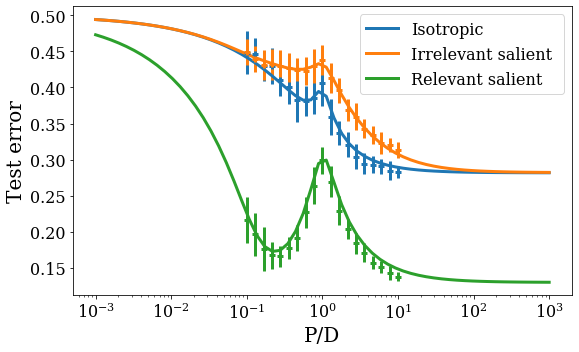

{'nonlinearity': 'tanh', 'lamb': 0.001, 'task': 'classification', 'delta': 0.3}


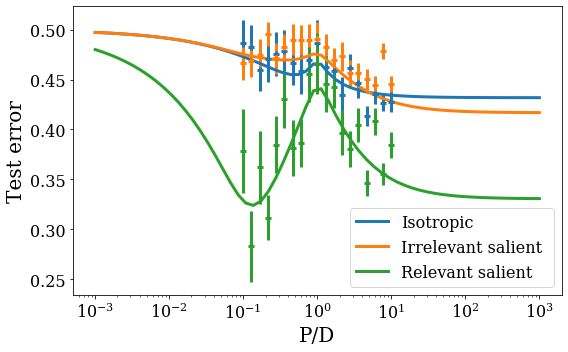

{'nonlinearity': 'tanh', 'lamb': 0.001, 'task': 'regression', 'delta': 0.0}


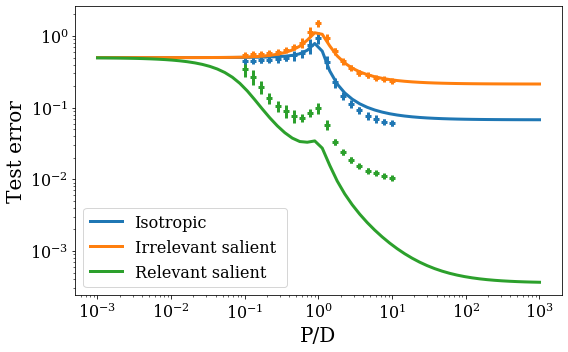

{'nonlinearity': 'tanh', 'lamb': 0.001, 'task': 'regression', 'delta': 0.3}


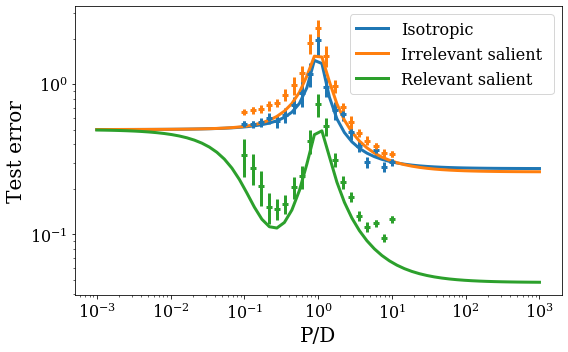

In [131]:
train = False

observable = 'tr_error' if train else 'te_error'
ylabel = 'Train error' if train else 'Test error'

parameter_wise = True if len(data['Psi1'].unique())>1 else False
plot_type = 'parameter_wise' if parameter_wise else 'sample_wise'
xkey = 'Psi1' if parameter_wise else 'Psi2'
xlabel = 'P/D' if parameter_wise else 'N/D'

constraints = {
'nonlinearity': list(set(data['nonlinearity'])),
'lamb': sorted(list(set(data['lamb']))),
'task': sorted(list(set(data['task']))),
'delta': sorted(list(set(data['delta']))),
}

constraints2 = {
'rx': sorted(list(set(data['rx']))),
'rb': sorted(list(set(data['rb']))),
'rphi': sorted(list(set(data['rphi']))),
}


for cons in dict_product(constraints):
    
    print(cons)
    icolor=0

    fig = plt.figure(figsize=(8,5))
    data1 = select_data(data, cons)
    ax = fig.add_subplot(111)

    for cons2 in dict_product(constraints2):
        
        if cons2['rx']==1 and cons2['rb']!=constraints2['rb'][0]: continue
        if cons2['rx']==1:
            label='Isotropic'
        else:
            if cons2['rb'] == 1:  continue#label = 'Normal salient '
            elif cons2['rb'] > 1: label = 'Relevant salient '
            elif cons2['rb'] < 1: label = 'Irrelevant salient '
        color = 'C%d'%icolor
        icolor+=1

        data2 = select_data(data1, cons2)
        
        ax.plot(data2[xkey], data2[observable], label=label, color=color)

        ax.set_xscale('log')
        ax.set_yscale('log')        
        if cons['task']=='classification': 
            ax.set_yscale('linear')
        if train:
            ax.set_yscale('linear')
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        
        runs = torch.load(datadir+'{}_{}_{}.pyT'.format(plot_type,cons['task'],cons['delta']))
        run = runs[(cons2['rx'],cons2['rb'])]
        args= run['args']
        x = args['Psi1_list'] if parameter_wise else args['Psi2_list']
        ax.errorbar(x, run[observable], yerr= run[observable+'_std'], color=color, ls='none', marker='+', mew=3)
        #ax.plot(x, run[observable], color=color, ls='none', marker='+', mew=3)
                    
    ax.legend()
    plt.tight_layout()    
    plt.savefig(savedir+'agreement_{}_{}_{}_noise{}_lamb{}_{}.pdf'.format(plot_type, observable, cons['nonlinearity'], cons['delta'], cons['lamb'], cons['task']))
    
    plt.show()

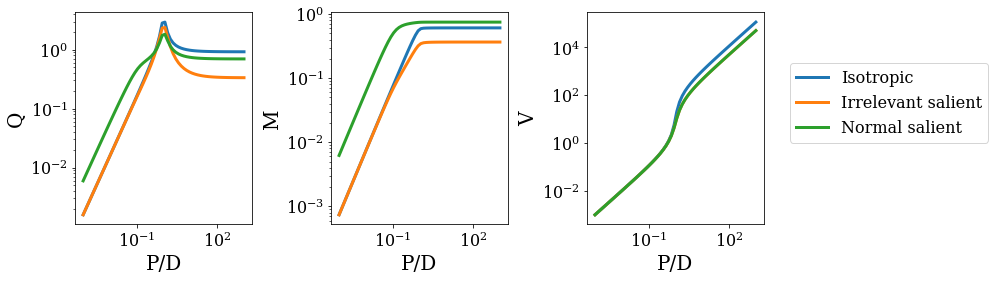

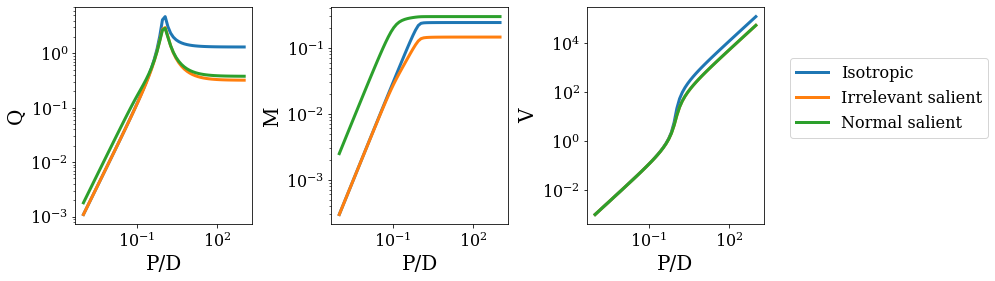

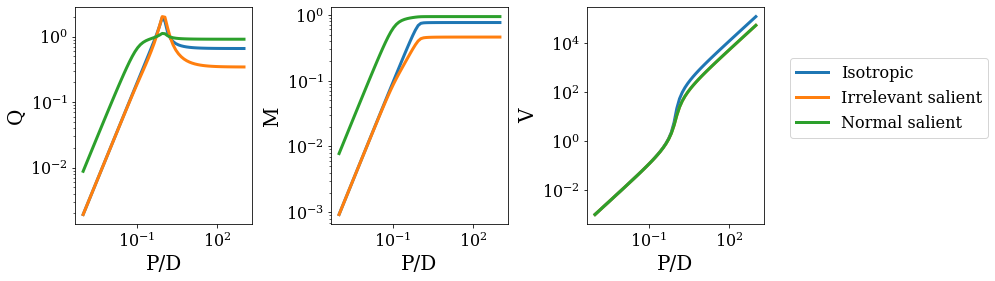

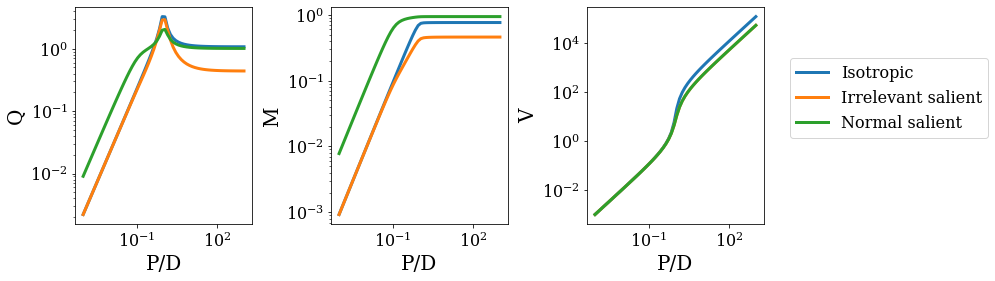

In [75]:
train = False

observable = 'tr_error' if train else 'te_error'
ylabel = 'Train error' if train else 'Test error'

parameter_wise = True if len(data['Psi1'].unique())>1 else False
plot_type = 'parameter_wise' if parameter_wise else 'sample_wise'
xkey = 'Psi1' if parameter_wise else 'Psi2'
xlabel = 'P/D' if parameter_wise else 'N/D'

constraints = {
'nonlinearity': sorted(list(set(data['nonlinearity']))),
'lamb': sorted(list(set(data['lamb']))),
'task': sorted(list(set(data['task']))),
'delta': sorted(list(set(data['delta']))),
}

constraints2 = {
'rx': sorted(list(set(data['rx']))),
'rb': sorted(list(set(data['rb']))),
'rphi': sorted(list(set(data['rphi']))),
}


for cons in dict_product(constraints):
    
    icolor=0

    fig, axarr = plt.subplots(1,3,figsize=(14,4))
    data1 = select_data(data, cons)
    
    num_runs = torch.load(datadir+'{}_{}_{}.pyT'.format(plot_type,cons['task'],cons['delta']))

    for cons2 in dict_product(constraints2):
        
        if cons2['rx']==1 and cons2['rb']!=constraints2['rb'][0]: continue
        if cons2['rx']==1:
            label='Isotropic'
        else:
            if cons2['rb'] == 1:  label = 'Normal salient'
            elif cons2['rb'] > 1: continue#label = 'Relevant salient features '
            elif cons2['rb'] < 1: label = 'Irrelevant salient'
        color = 'C%d'%icolor
        icolor+=1

        data2 = select_data(data1, cons2)

        ax.set_xscale('log')
        ax.set_yscale('log')        
        if cons['task']=='classification': 
            ax.set_yscale('linear')
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        
        axarr[0].plot(data2[xkey], data2['Q'], label=label)
        axarr[1].plot(data2[xkey], data2['M'], label=label)
        axarr[2].plot(data2[xkey], data2['V'], label=label)
        axarr[0].set_ylabel('Q')        
        axarr[1].set_ylabel('M')        
        axarr[2].set_ylabel('V')        
                    
    for ax in axarr:
        ax.set_xscale('log')
        ax.set_yscale('log')        
        ax.set_xlabel(xlabel)
    axarr[2].legend(bbox_to_anchor=(1.1,.8))
    plt.tight_layout()    
    plt.savefig(savedir+'order_params_{}_{}_noise{}_lamb{}_{}.pdf'.format(plot_type, cons['nonlinearity'], delta, cons['lamb'], cons['task']))
    
    plt.show()

# Varying $r_\phi$

In [32]:
data = torch.load(datadir+'varying_rphi_parameter_wise.pkl')
#data = torch.load(datadir+'varying_rphi_sample_wise.pkl')
data = pd.DataFrame.from_dict(data)

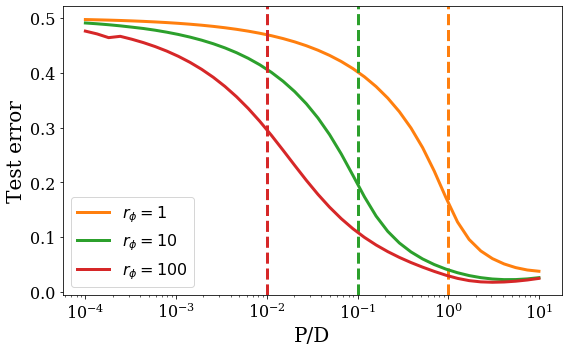

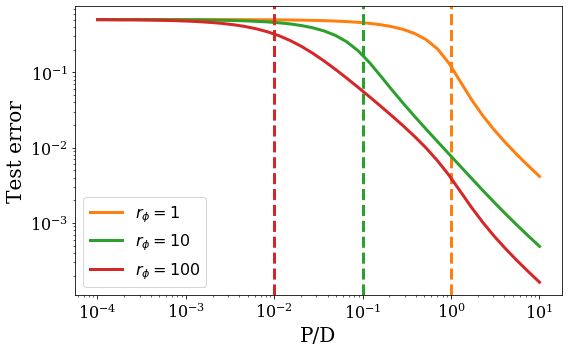

In [33]:
train = False

observable = 'tr_error' if train else 'te_error'
ylabel = 'Train error' if train else 'Test error'

parameter_wise = True if len(data['Psi1'].unique())>1 else False
plot_type = 'parameter_wise' if parameter_wise else 'sample_wise'
xkey = 'Psi1' if parameter_wise else 'Psi2'
xlabel = 'P/D' if parameter_wise else 'N/D'

constraints = {
'nonlinearity': list(set(data['nonlinearity'])),
'lamb': sorted(list(set(data['lamb']))),
'task': sorted(list(set(data['task']))),
'delta': sorted(list(set(data['delta']))),
'rx': sorted(list(set(data['rx']))),
}

constraints2 = {
'rb': sorted(list(set(data['rb']))),
'rphi': sorted(list(set(data['rphi']))),
}


for cons in dict_product(constraints):
    
    icolor=0

    fig = plt.figure(figsize=(8,5))
    data1 = select_data(data, cons)
    ax = fig.add_subplot(111)

    for cons2 in dict_product(constraints2):
        
        if cons['rx']==1 and cons2['rb']!=constraints2['rb'][0]: continue
        icolor+=1
        color = 'C%d'%icolor

        data2 = select_data(data1, cons2)
        
        label = r'$r_\phi={}$'.format(cons2['rphi'])
        ax.axvline(x = 1/cons2['rphi'], color=color, ls='--')        
        
        ax.plot(data2[xkey], data2[observable], label=label, color=color)

        ax.set_xscale('log')
        ax.set_yscale('log')        
        if cons['task']=='classification': 
            ax.set_yscale('linear')
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
                
    ax.legend()
    plt.tight_layout()    
    plt.savefig(savedir+'varying_rphi_{}_{}_{}_noise{}_lamb{}_{}.pdf'.format(plot_type, observable, cons['nonlinearity'], delta, cons['lamb'], cons['task']))
    
    plt.show()

# Phase space

In [139]:
#data = torch.load(datadir+'phase_space_rx.pkl')
#data = torch.load(datadir+'phase_space.pkl')
data = pd.DataFrame.from_dict(data)

phase_space_te_error_rx1_rb1000_relu_noise0.0_lamb0.1_classification.pdf


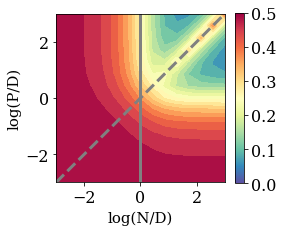

phase_space_te_error_rx10_rb1000_relu_noise0.0_lamb0.1_classification.pdf


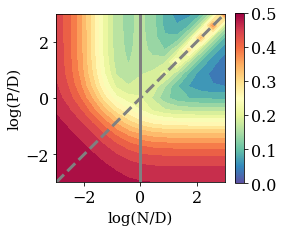

phase_space_te_error_rx100_rb1000_relu_noise0.0_lamb0.1_classification.pdf


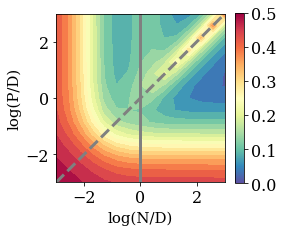

phase_space_te_error_rx1000_rb1000_relu_noise0.0_lamb0.1_classification.pdf


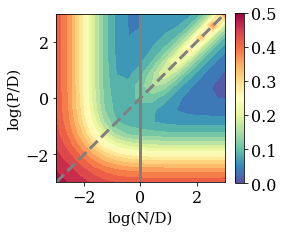

In [138]:
%matplotlib inline

train = False
observable = 'tr_error' if train else 'te_error'
vmin = 0 if not train else None
vmax = .5 if not train else None

constraints = {
'nonlinearity': sorted(list(set(data['nonlinearity']))),
'lamb': sorted(list(set(data['lamb']))),
'delta': sorted(list(set(data['delta']))),
'task': sorted(list(set(data['task']))),
'rphi': sorted(list(set(data['rphi']))),
'rx': sorted(list(set(data['rx']))),
'rb': sorted(list(set(data['rb']))),
}

for cons in dict_product(constraints):
    
    
    fig, ax = plt.subplots(figsize=(4,4))
    
    data1 = select_data(data, cons)
    if len(data1)==0:continue
    
    x = np.log10(data1['Psi2'])
    y = np.log10(data1['Psi1'])
    X, Y, Z = df_to_arrays(data1, 'Psi1', 'Psi2', observable)
    X, Y = np.log10(X), np.log10(Y)
    if cons['task']=='regression' or observable in ['Q','M','V','tr_error']: Z = np.log10(Z)
    im = ax.contourf(X, Y, Z, cmap=cmap, levels=20, vmin=vmin, vmax=vmax)
    ax.set_xlabel(r'log(N/D)', fontsize=15)
    ax.set_ylabel(r'log(P/D)', fontsize=15)
    ax.axis('scaled')
    m = plt.cm.ScalarMappable(cmap=cmap)
    m.set_array(Z)
    m.set_clim(vmin, vmax)
    plt.colorbar(m, ax=ax, shrink=.7)
    #cbar.set_clim(m)
    ax.axvline(x=0, ls='-', color='grey', label='N=D')
    ax.plot([max(min(x), min(y)), min(max(x), max(y))], [max(min(x), min(y)), min(max(x), max(y))], 
                ls='--', color='grey', label='N=P')
    #ax.legend(loc='upper right')
    #ax.legend(loc='lower right', fontsize=12)
                            
    title = 'phase_space_{}_rx{}_rb{}_{}_noise{}_lamb{}_{}.pdf'.format(observable, cons['rx'], cons['rb'], cons['nonlinearity'], cons['delta'], cons['lamb'], cons['task'])
    print(title)
    plt.tight_layout()
    plt.savefig(savedir+title)

    plt.show()

# Regularization

In [ ]:
data = torch.load('regularization.pkl')
data = pd.DataFrame.from_dict(data)

constraints = {
'Psi1': sorted(list(set(data['Psi1'])))[1],
'Psi2': sorted(list(set(data['Psi2'])))[0],
}
data = select_data(data, constraints)

In [ ]:
deltas= sorted(list(set(data['delta'])))

data['betas'] = data['betas'].apply(lambda x: tuple(x))
data['cs'] = data['cs'].apply(lambda x: tuple(x))
data['ds'] = data['ds'].apply(lambda x: tuple(x))

constraints = {
'task': sorted(list(set(data['task']))),
'nonlinearity': sorted(list(set(data['nonlinearity']))),
'Psi1': sorted(list(set(data['Psi1']))),
'Psi2': sorted(list(set(data['Psi2']))),
'task': sorted(list(set(data['task']))),
'cs': data['cs'].unique(),
'betas': data['betas'].unique()
}

fig, axarr = plt.subplots(1,len(deltas),figsize=(8*len(deltas),5))
for cons in dict_product(constraints):
    data1 = select_data(data, cons)
    for i, delta in enumerate(deltas):
        data2 = select_data(data1, {'delta': delta})
        data2.plot(x='lamb', y='te_error', ax=axarr[i], legend=False,
                  label = r'$\lambda_1/\lambda_2={0:.2f}, \beta_1/\beta_2={1:.2f}$'.format(cons['cs'][0]/cons['cs'][1], 
                                                                                          cons['betas'][0]/cons['betas'][1]))
        axarr[i].set_xlabel(r'$\lambda$')
        axarr[i].set_ylabel('Test loss')
        axarr[i].set_title('noise={}'.format(delta))
for ax in axarr:
    ax.legend()
    ax.set_yscale('log')
    
plt.tight_layout()
plt.savefig(savedir+'regularization.pdf')